# Iterative procedure with DYN3D

This Notebook demonestrates how to calculate correction factors (i.e., axial ADFs in this case) using the built-in JFNK procedure within the ``xsInterface`` package.

First, cross sections are read from a serpent ``_res.m`` file.
This notebook shows how to execute DYN3D iteratively using the ``Iterate`` method.

It is important to note that the solution presented here was validated against a consistent semi-analytic solution (not presented here).

## Case Description

<img src="figures/supercell.png" alt="alt text" width="30%" height="auto" class="blog-image">

The ``.\inputs`` directory includes:
- ``case1_lumped_big_res` a serpent results file with all the cross sections.
- ``univs`` a file that describes how to read ``case1_lumped_big_res.m``
- ``template_dyn3d_2g_fuel`` is a template file that specifies how cross sections should be printed out for the fuel and moderator elements.
- ``controlDict`` the main files that is required by the ``xsInterface``.

The ``.\dyn3d`` includes a pre-generated DYN3D case. The ``.\dyn3d\xs`` directory will include all the files with printed cross sections required by DYN3D.

### Required imports

In [1]:
from xsInterface.functions.main import Main

In [2]:
# a class required to execute DYN3D
from xsInterface.functions.dyn3d import DYN3D

In [3]:
inputFile = ".\\inputs\\controlDict"

### Read the cross sections

In [4]:
# Reset the main object
xs = Main(inputFile)

... Reading control dict ...
<.\inputs\controlDict>



#### Read xs data without populating the templates

In [5]:
# readTemplate allows to read and populate data using the templates
xs.Read(readUniverses=True)

SERPENT Serpent 2.1.32 found in ./serpent/case1_lumped_big_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.


... Reading universe <u> ...
... Reading coe/_res.m file for hisotry <nom> ...


### Populate cross sections

In the ``".\\inputs\\controlDict"`` the user defined the core map used to populate the cross sections according to their channels and layers positions.

In our problem we have 1 channel and 38 axial layers.

**Define states**
These states must exist and be used to obtain the cross sections for different channels and layers.

In [6]:
nchs = 2
nlayers = 1
states = {
'history':[['nom']*nlayers]*nchs,
'time': [[0.0]*nlayers]*nchs,
'dens': [[700.]*nlayers]*nchs,
}

**Populate core data**
built-in capability to populate the data according to the defined map including defining new variables not listed in the original ``univs`` file.
This is a **mandaory** step if the intent is to execute DYN3D.

In [7]:
volmanip = {'infflx': 'divide'}
xs.PopulateCoreData(
                    states=states, 
                    attributes=None,  # specify only if specific attrs needed
                    volManip=volmanip,
                    adf=None, bottomadf=None, topadf=None, sph=None,)

### Iteratively execute DYN3D

In [9]:
casedir = ".\\dyn3d"   # dyn3d dir
casefile = "case1"  # name of dyn3d file
exefile = "RUN_DYN3D" # dyn3d executuin file

# Reset the object
reslt = DYN3D(xs, casedir, casefile, exefile)

**Set the refernce flux**

In [10]:
refFlx = xs.core.corevalues['infflx']

**Execute**

The files will be written to the specified directories and then automatically executed.

In [11]:
reslt.Iterate(
    corrattrs=['adf'], refFlx=refFlx, newtonIters=5, krylovSpan=10,
    krylovErr=5E-05, newtonErr=1E-07,
    dampingF=0.8, lbound=0.5, ubound=1.5, pert=5E-03)

... Iterative JFNK ...
Newton #0/5
Arnoldi # 1(1.78e-03/1.80e-03) 2(1.80e-04/9.11e-04) 3(4.70e-15/2.80e-03)
Newton #1/5
Arnoldi # 1(5.22e-04/5.48e-04) 2(1.81e-04/2.53e-04) 3(7.66e-17/2.05e-04)
Newton #2/5
Arnoldi # 1(9.15e-05/7.23e-05) 2(5.78e-06/4.70e-05) 3(7.60e-16/5.34e-05)
Newton #3/5
Arnoldi # 1(3.49e-05/3.50e-05) 2(2.94e-05/1.82e-05) 3(1.66e-17/1.82e-05)
Newton #4/5
Arnoldi # 1(1.70e-05/1.78e-05) 2(1.62e-05/1.18e-05) 3(3.56e-17/1.18e-05)


### Compare results against Serpent

Plot the results for flux and its corresponding difference. Finally, plot the convergence as a function of newton iteration number.

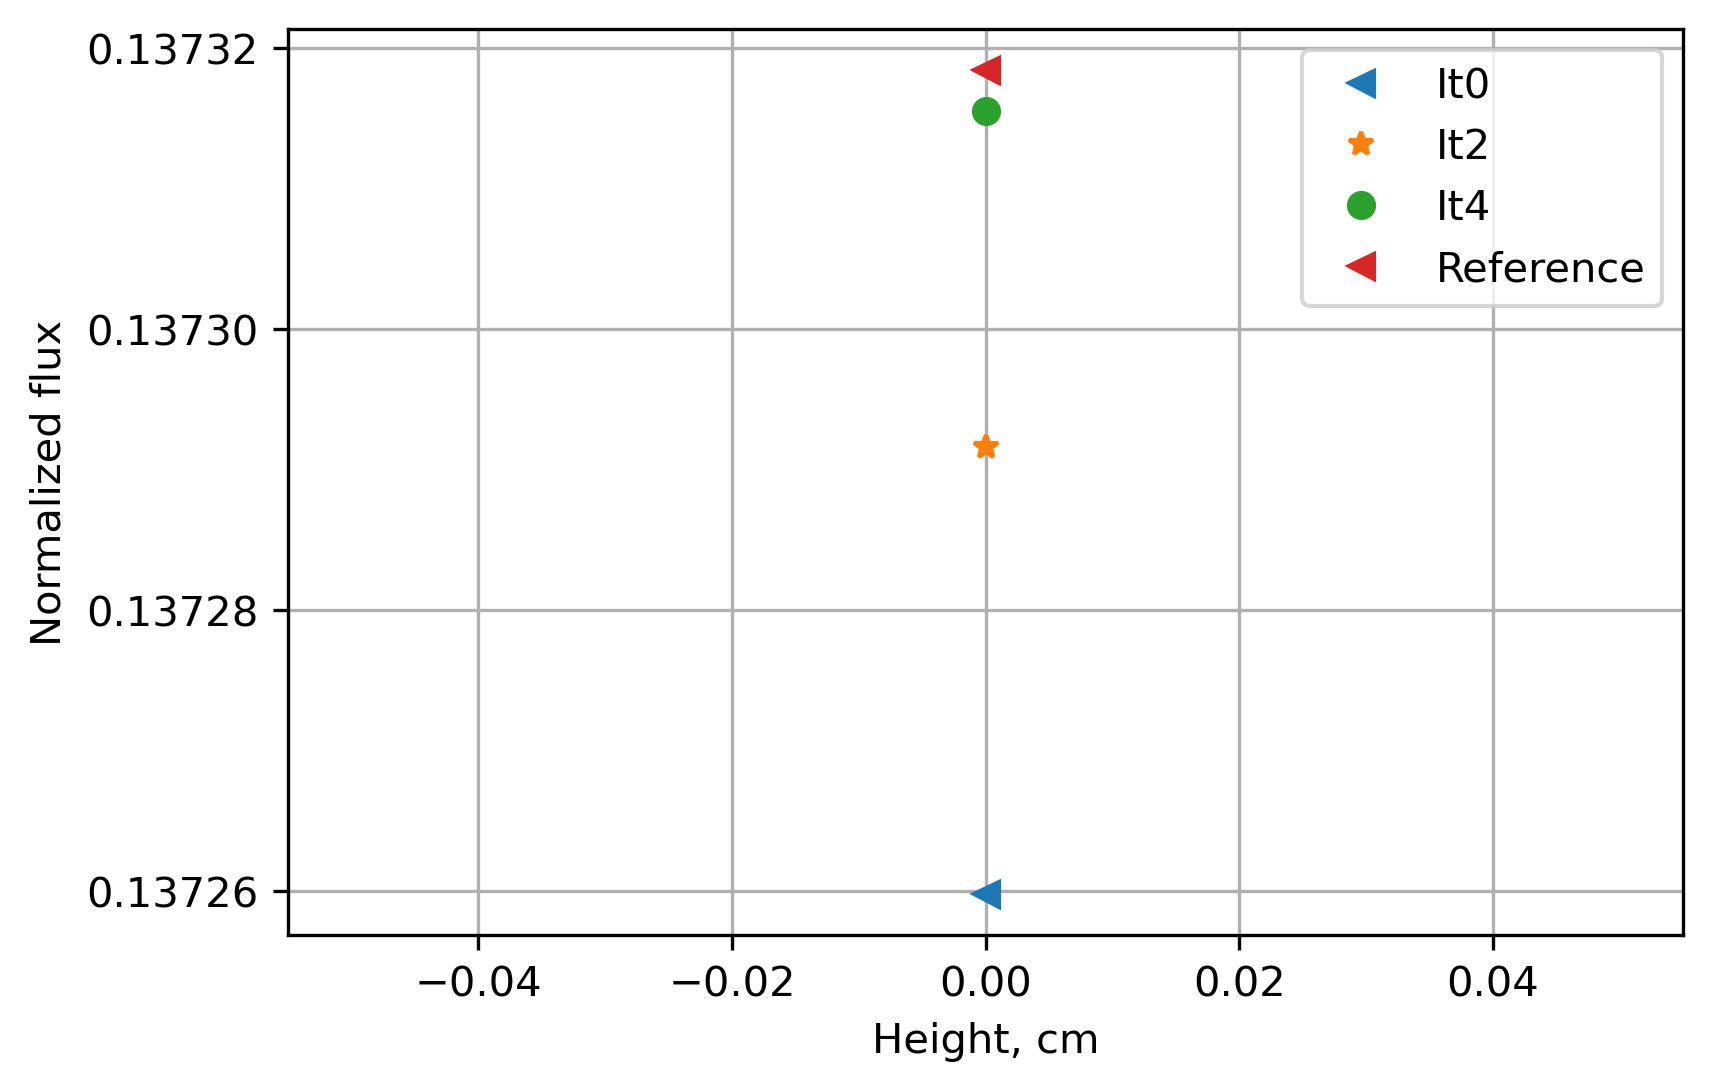

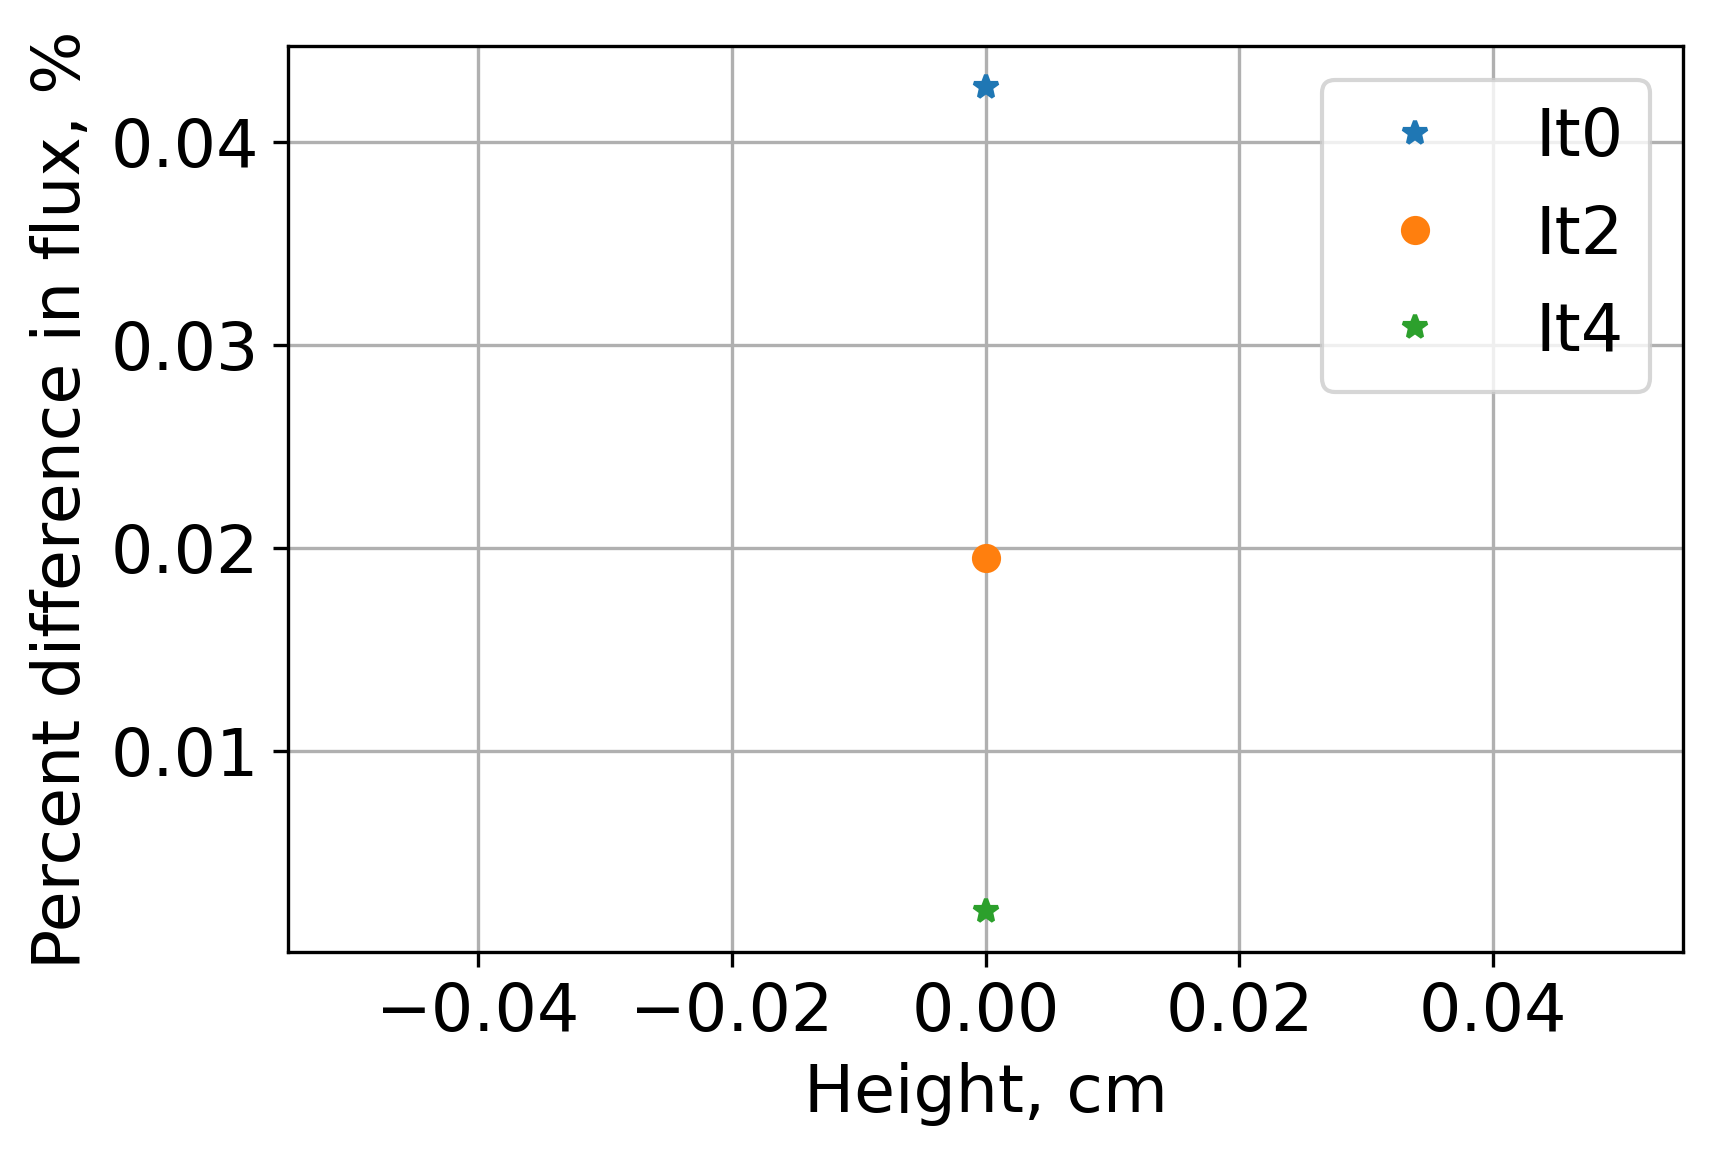

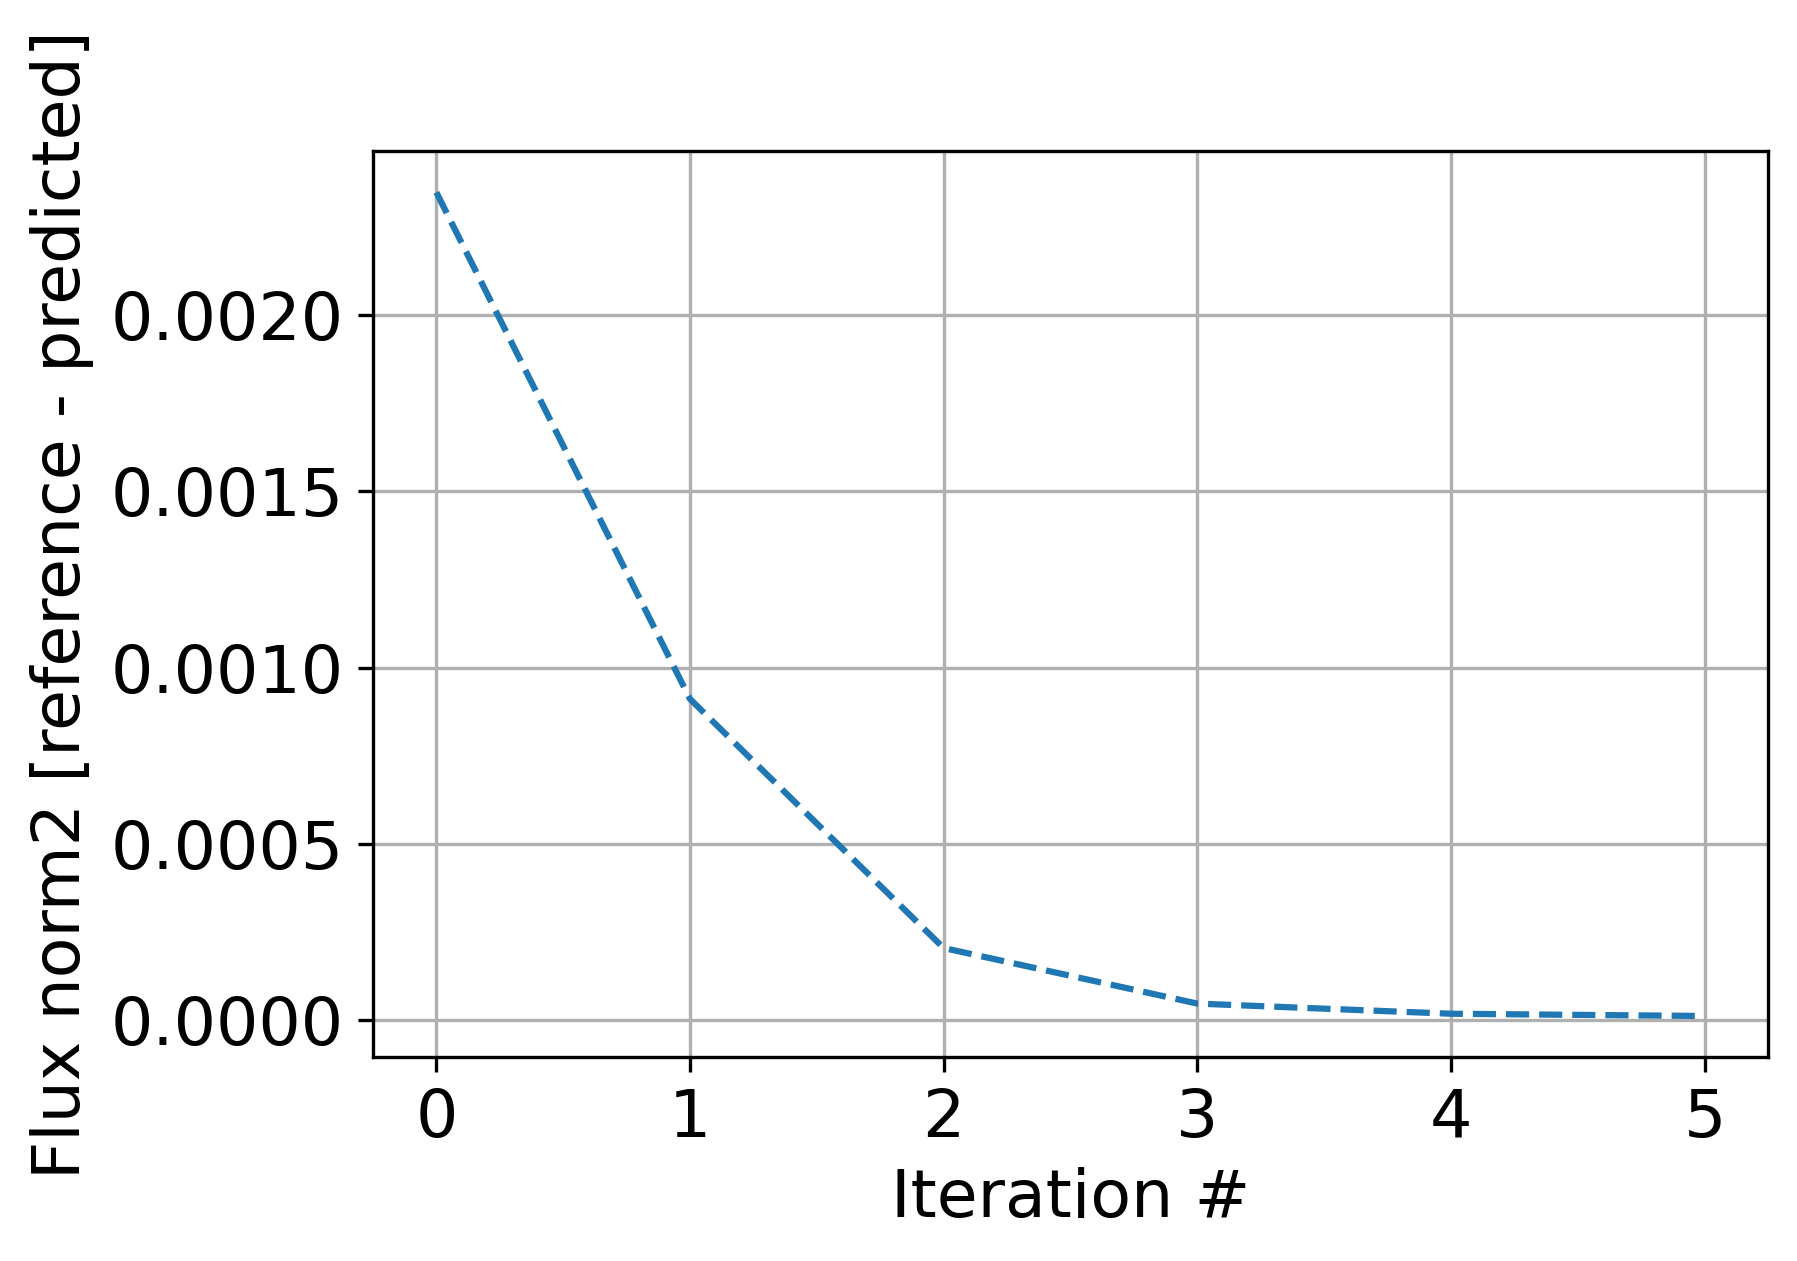

In [12]:
import numpy as np
reslt.PlotFluxes([0], iters=np.array([0, 2, 4]),  markers=['<', '*', 'o'], chId="S2")

**Plot the reference fluxes in the Fast group and Thermal group respectively**

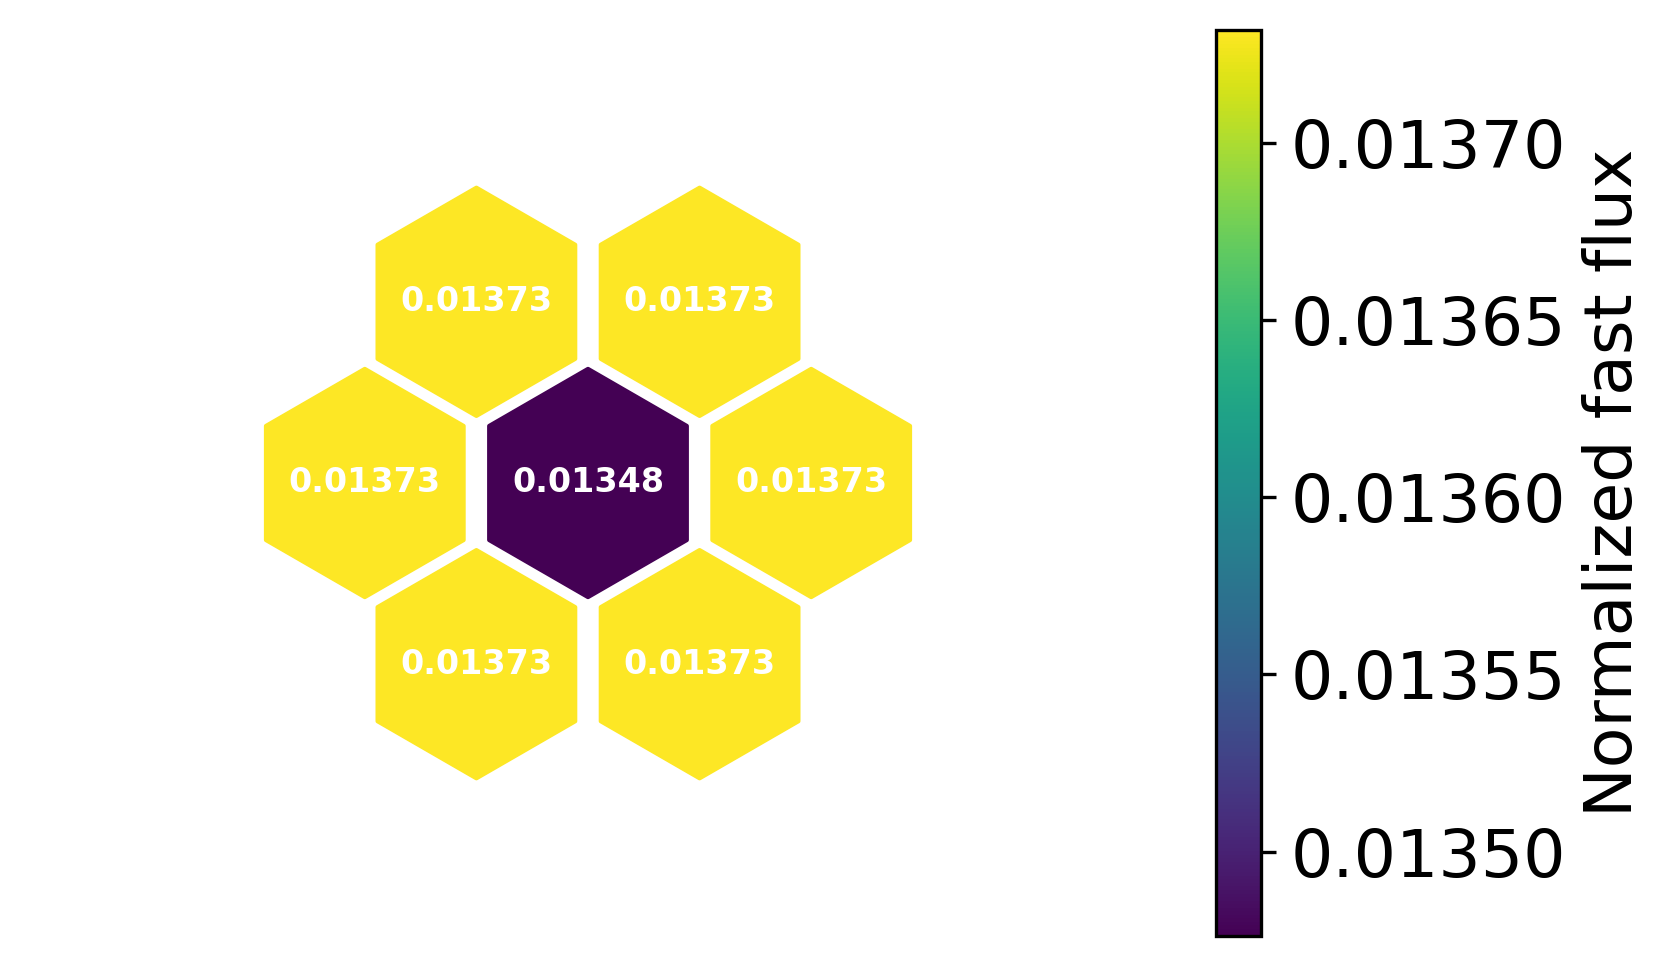

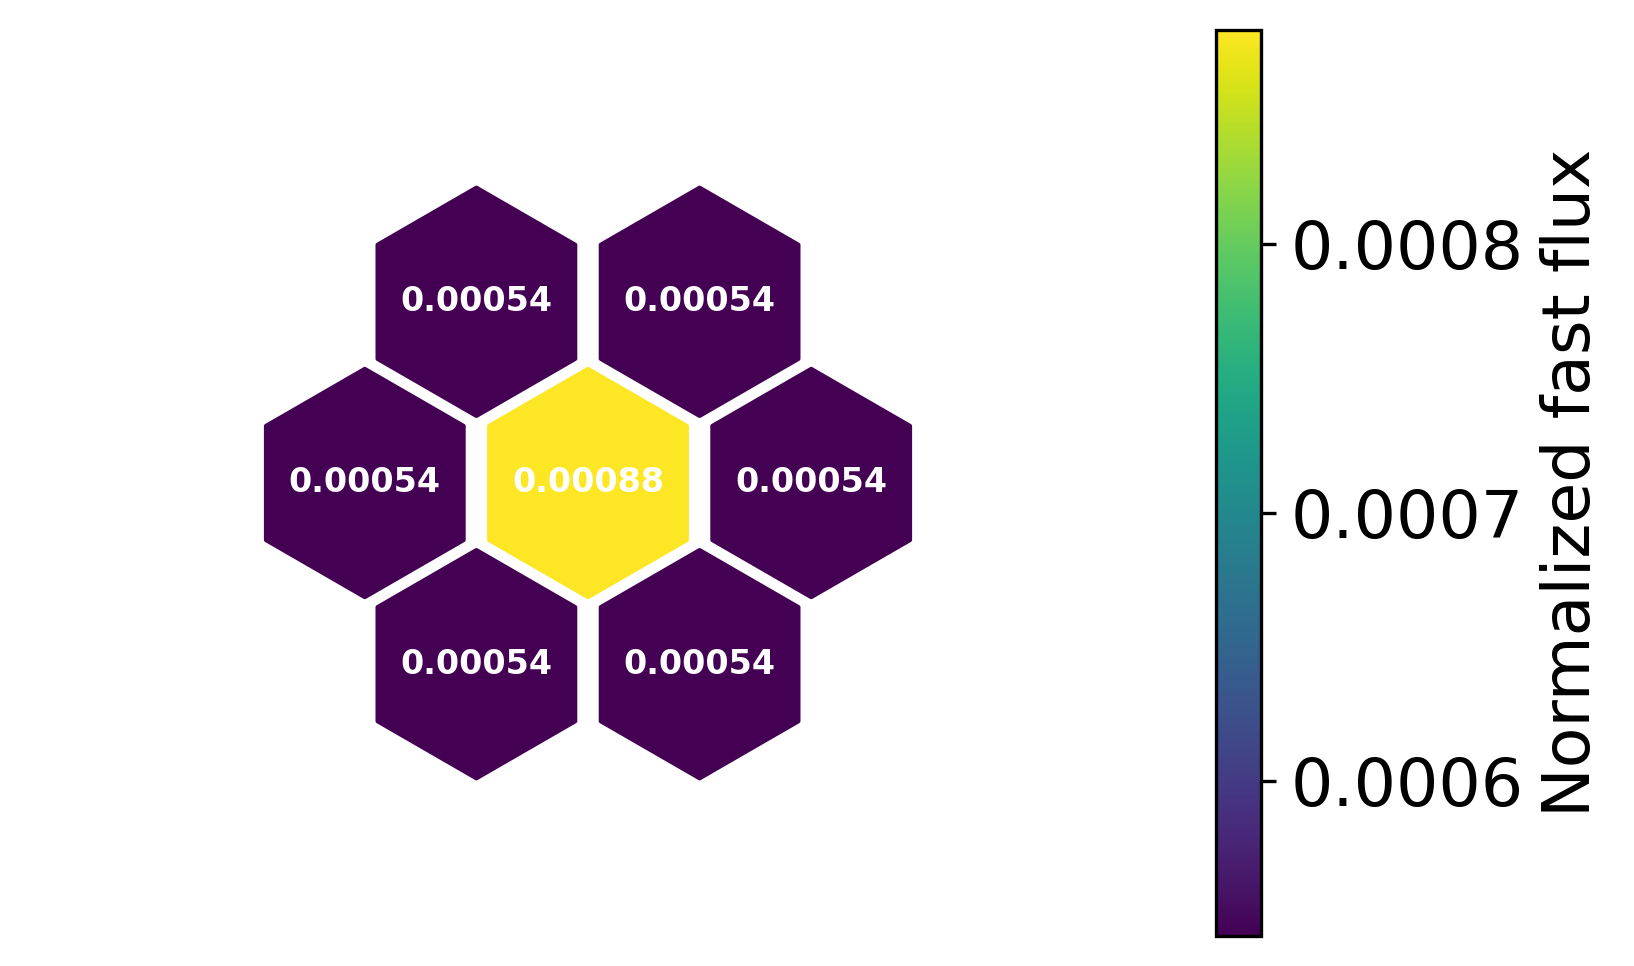

In [13]:
xs.SlicePlot(reslt.refFlx, layer=0, markersize=3000, spacesize=2.0,
              textsize=8, textcolor='w', textweight="bold", 
              precision=".5f", edge=1.5, norm=10.0, label="Normalized fast flux", 
              egroup=0, geomarker='h', shift=[-0.5, 0, -0.5])
xs.SlicePlot(reslt.refFlx, layer=0, markersize=3000, spacesize=2.0,
              textsize=8, textcolor='w', textweight="bold", 
              precision=".5f", edge=1.5, norm=10.0, label="Normalized fast flux", 
              egroup=1, geomarker='h', shift=[-0.5, 0, -0.5])


**Plot the flux differences in the Fast group and Thermal group respectively** Without iterating on ADFs.

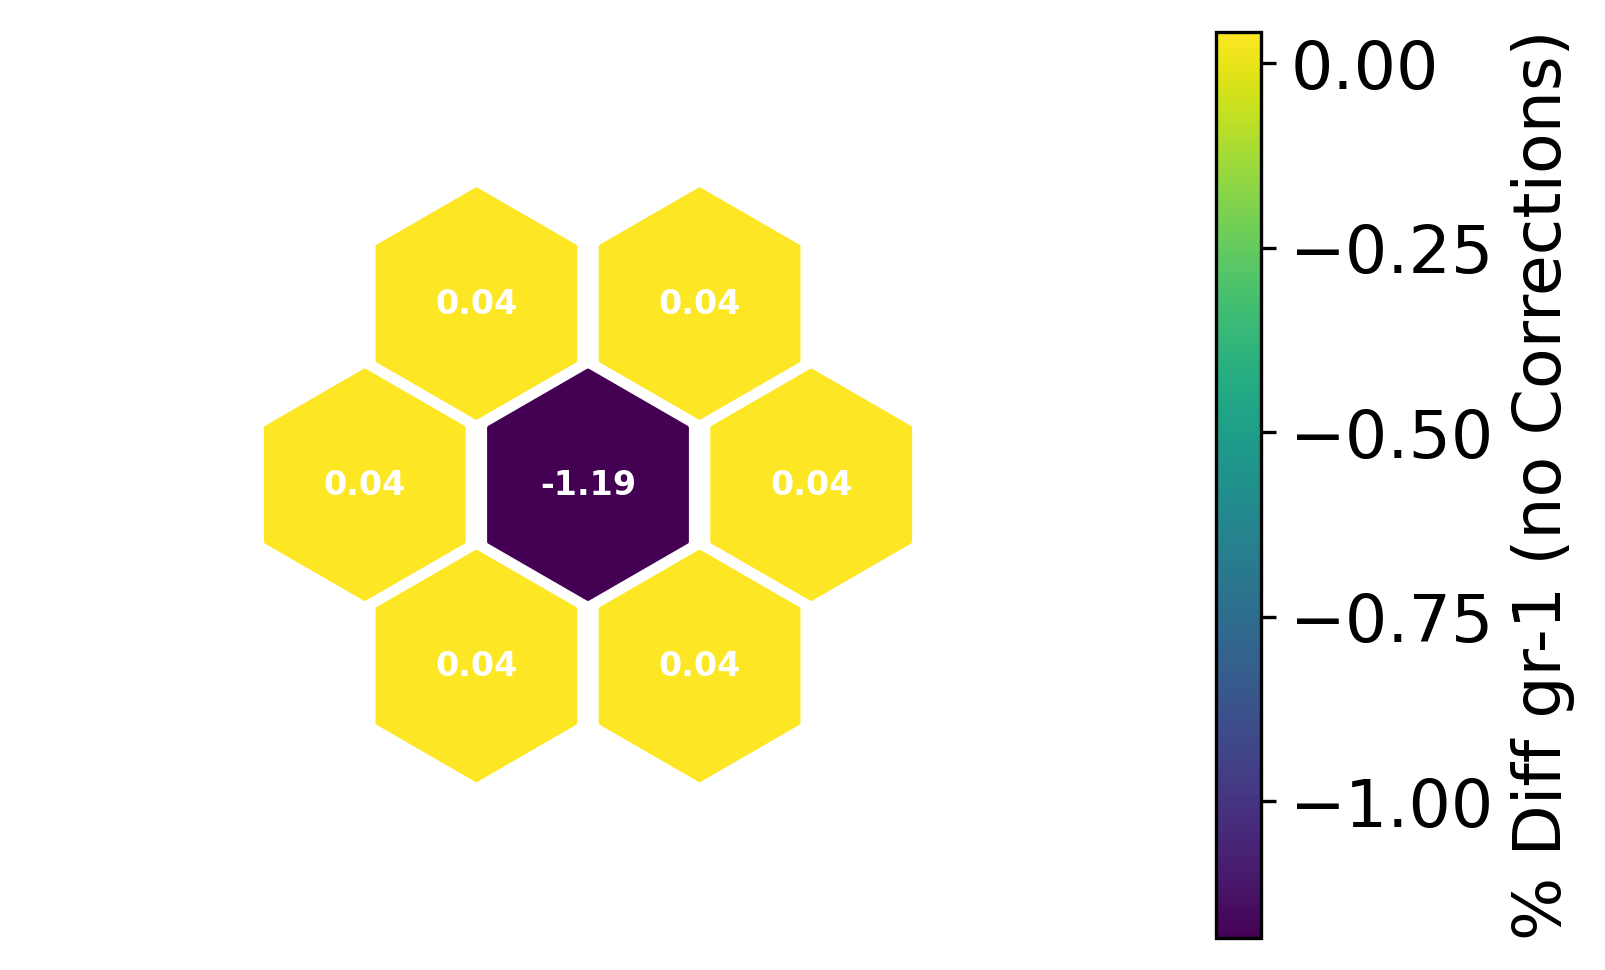

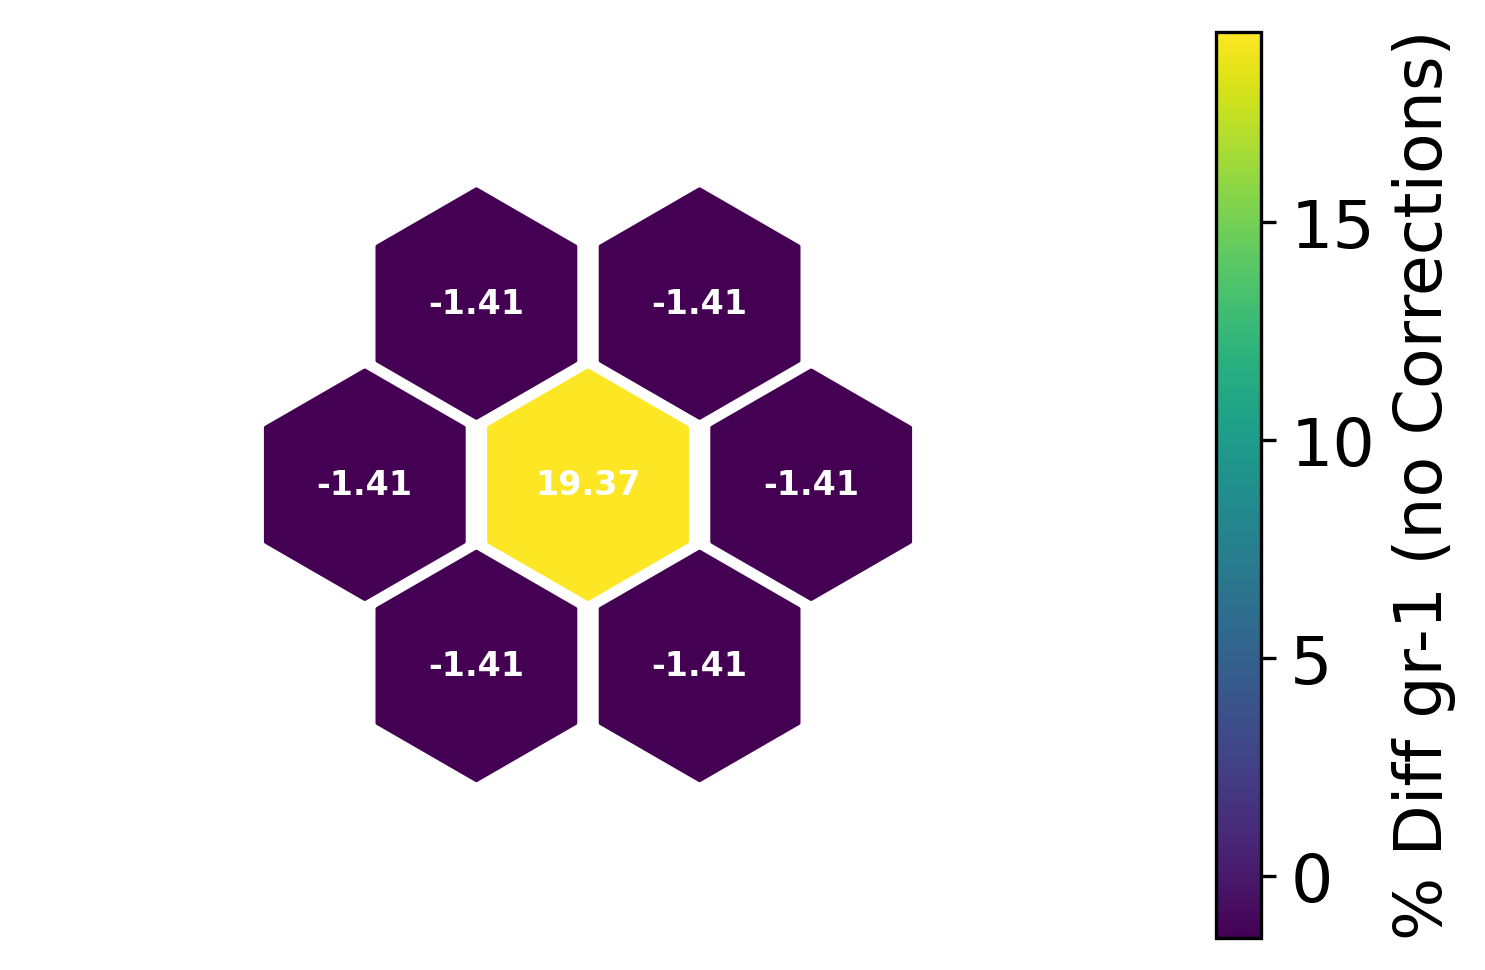

In [14]:
xs.SlicePlot(reslt.iterDifferences[0], layer=0, markersize=3000, spacesize=2.0,
              textsize=8, textcolor='w', textweight="bold", 
              precision=".2f", edge=1.5, norm=1.0, label="% Diff gr-1 (no Corrections)", 
              egroup=0, geomarker='h', shift=[-0.5, 0, -0.5])
xs.SlicePlot(reslt.iterDifferences[0], layer=0, markersize=3000, spacesize=2.0,
              textsize=8, textcolor='w', textweight="bold", 
              precision=".2f", edge=1.5, norm=1.0, label="% Diff gr-1 (no Corrections)", 
              egroup=1, geomarker='h', shift=[-0.5, 0, -0.5])

**Plot the flux differences in the Fast group and Thermal group respectively** After iterating on ADFs.

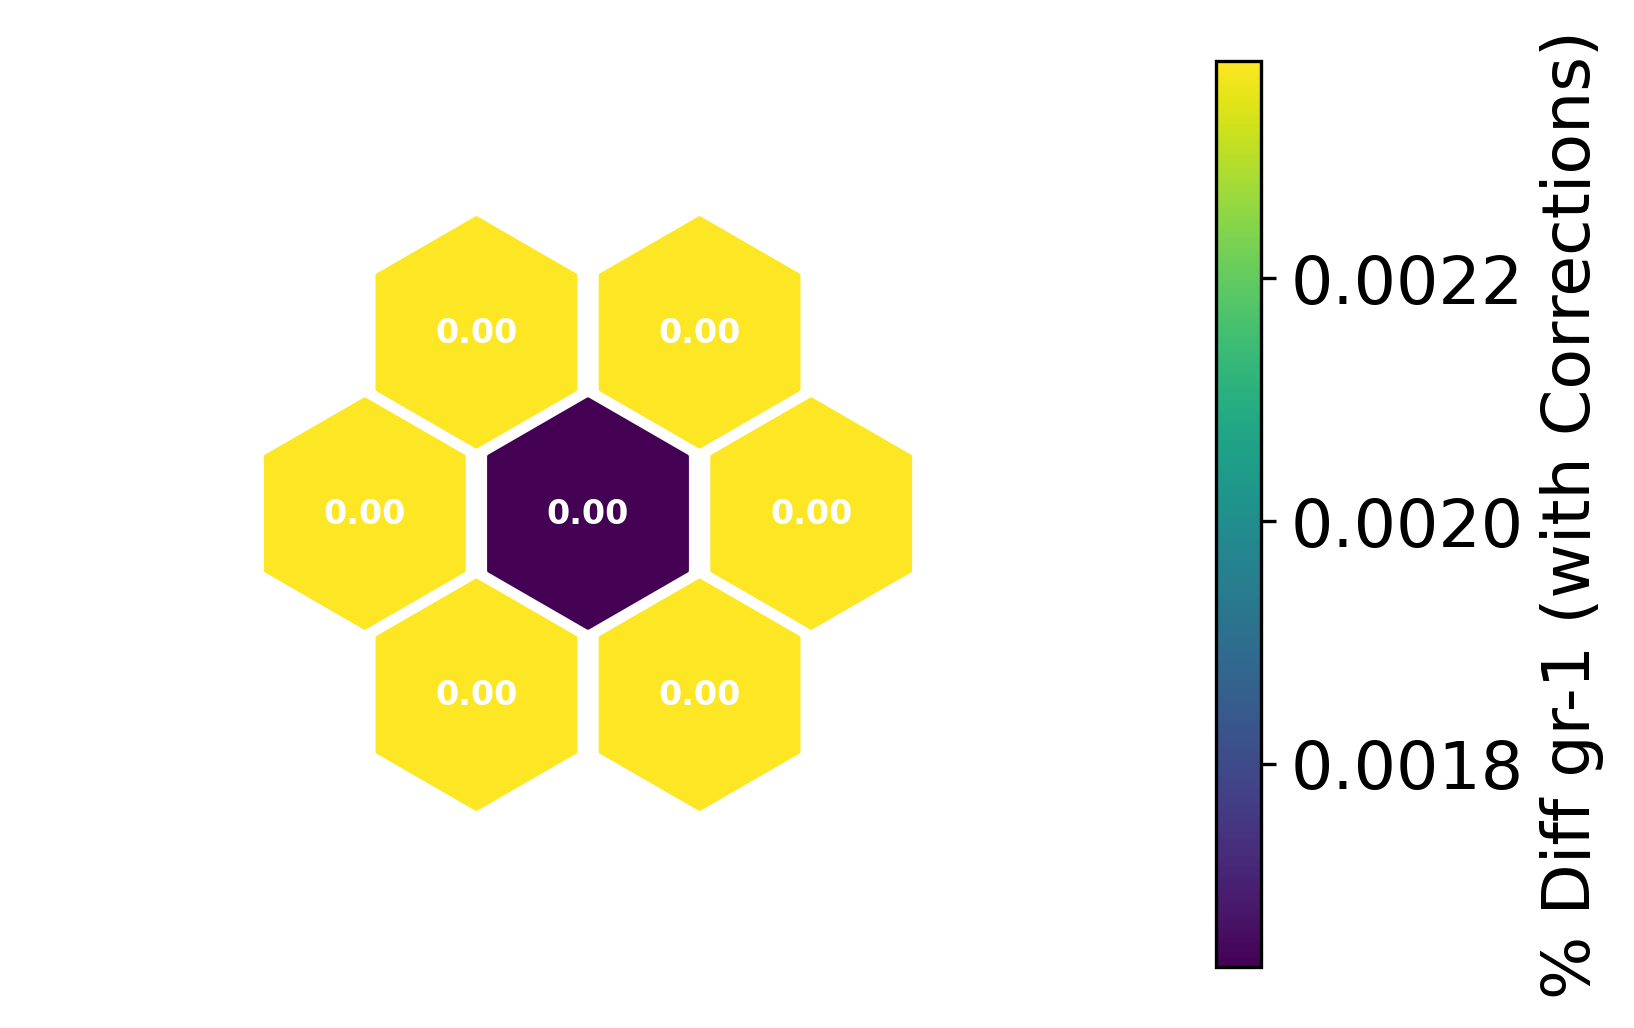

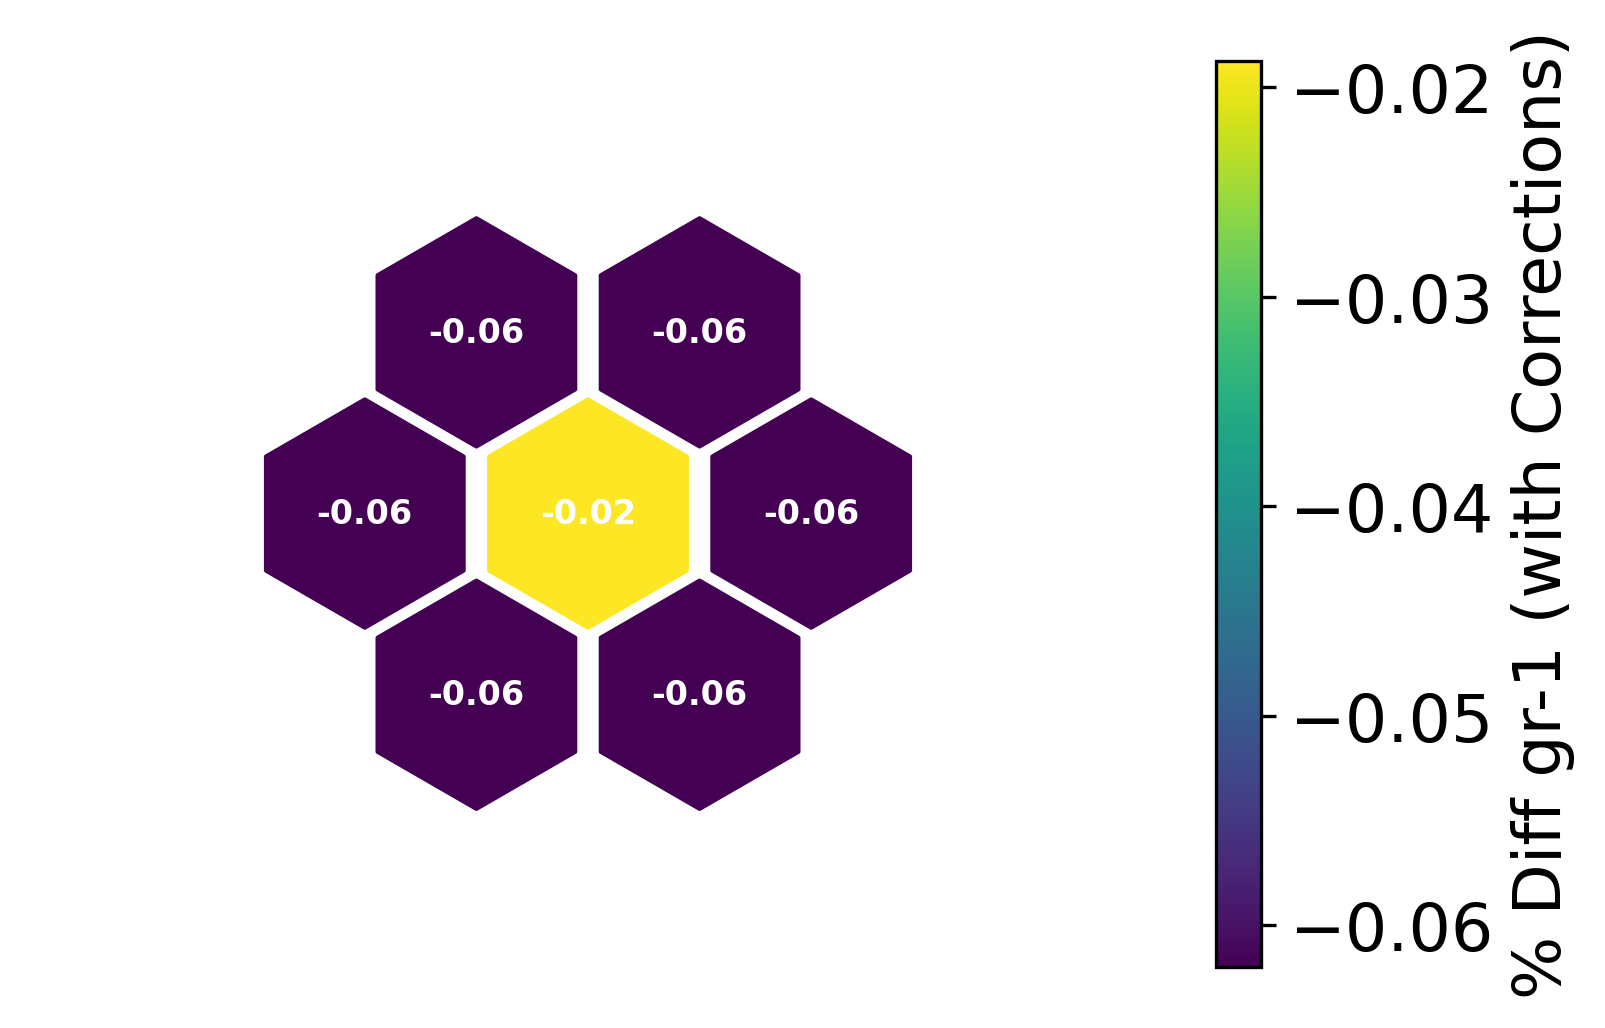

In [16]:
xs.SlicePlot(reslt.iterDifferences[-1], layer=0, markersize=3000, spacesize=2.0,
              textsize=8, textcolor='w', textweight="bold", 
              precision=".2f", edge=1.5, norm=1.0, label="% Diff gr-1 (with Corrections)", 
              egroup=0, geomarker='h', shift=[-0.5, 0, -0.5])
xs.SlicePlot(reslt.iterDifferences[-1], layer=0, markersize=3000, spacesize=2.0,
              textsize=8, textcolor='w', textweight="bold", 
              precision=".2f", edge=1.5, norm=1.0, label="% Diff gr-1 (with Corrections)", 
              egroup=1, geomarker='h', shift=[-0.5, 0, -0.5])

**Plot the resulting ADFs in the Fast group and Thermal group respectively**

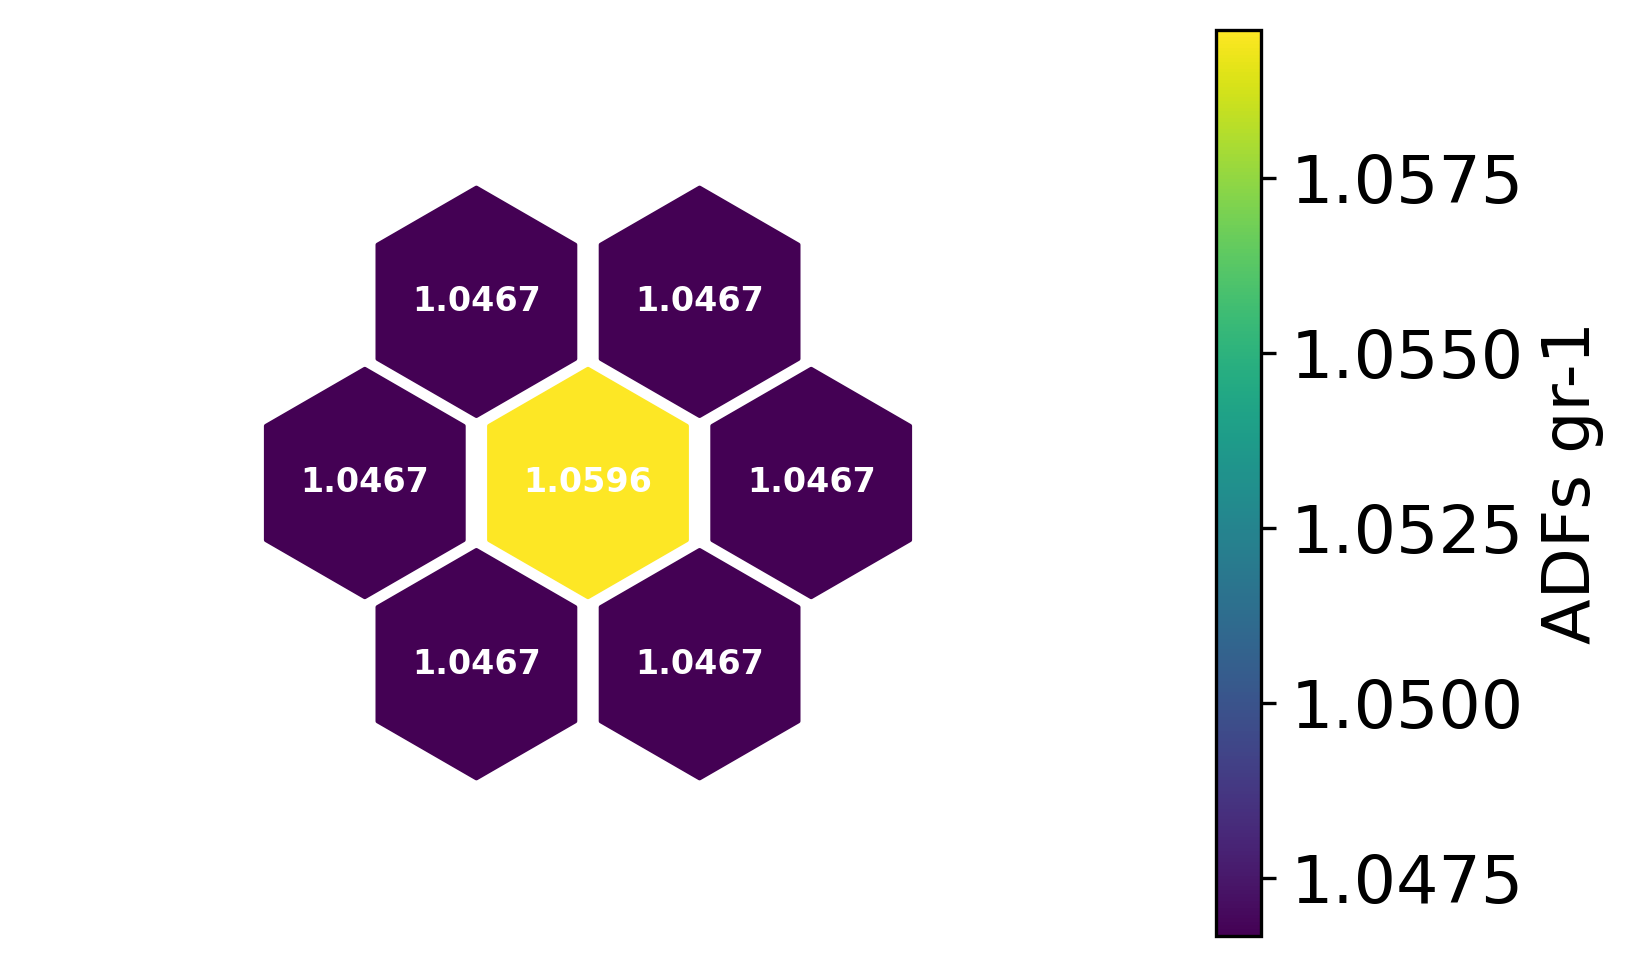

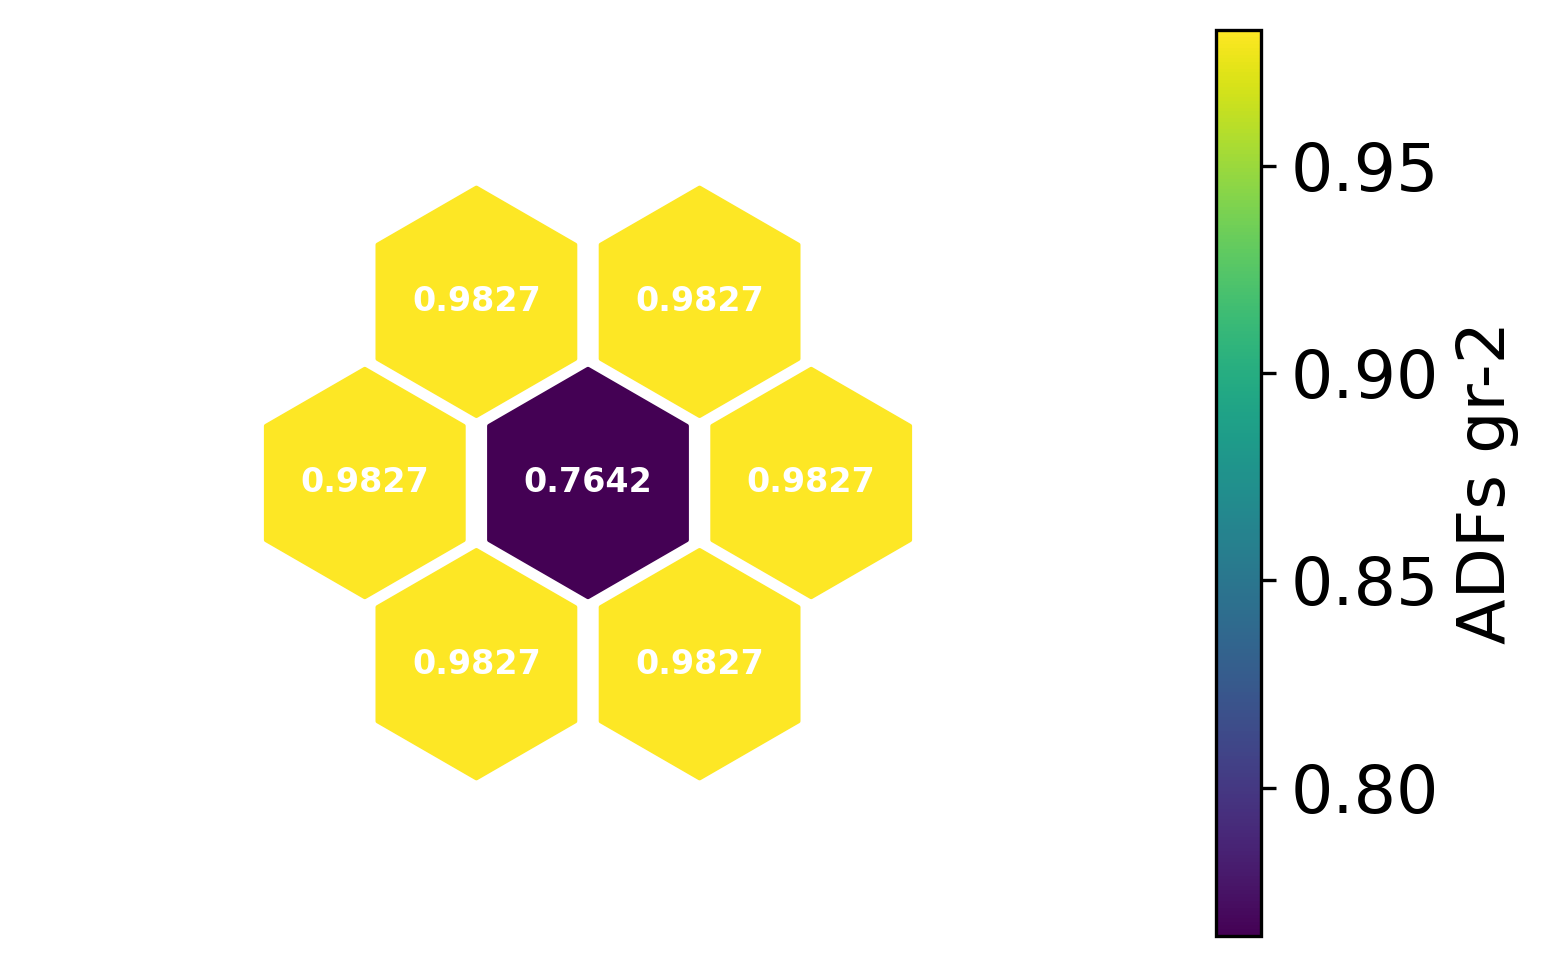

In [17]:
xs.SlicePlot(reslt.iterInputs['adf'][-1], layer=0, markersize=3000, spacesize=2.0,
              textsize=8, textcolor='w', textweight="bold", 
              precision=".4f", edge=1.5, norm=1.0, label="ADFs gr-1", 
              egroup=0, geomarker='h', shift=[-0.5, 0, -0.5])

xs.SlicePlot(reslt.iterInputs['adf'][-1], layer=0, markersize=3000, spacesize=2.0,
              textsize=8, textcolor='w', textweight="bold", 
              precision=".4f", edge=1.5, norm=1.0, label="ADFs gr-2", 
              egroup=1, geomarker='h', shift=[-0.5, 0, -0.5])
